## Часть первая, в которой появляются данные

### Импорты

In [1]:
from PIL import Image, ImageDraw, ImageOps
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

### Генерируем датасет

Сгенирируем синтетический датасет из `5000` изображений, каждое размером `64x64`. На каждом изображении расположено до `4` объектов, повернутых на случайный угол в диапазоне `[-45, 45]` градусов.

In [2]:
def one_hot(x, n_class):
    return [int(x == i) for i in range(n_class)]

In [3]:
dataset_size = 5000
n_class = 2
paths = ["src/doge_d.png", "src/cat_d.png", None]
labels = ["doge", "cat", "none"]
im_size = 16

cell_w = 32
cell_h = 32
grid_w = 2
grid_h = 2
image_w = grid_w * cell_w
image_h = grid_h * cell_h

random.seed(0)

In [11]:
for idx in range(1, dataset_size + 1):
    image = Image.new("RGB", (image_w, image_h), "black")
    draw = ImageDraw.Draw(image)

    with open(f"labels/{idx}.txt", "w+") as file:
        for row in range(grid_w):
            for col in range(grid_h):
                j = random.randint(0, n_class)
                label, path, vec = labels[j], paths[j], one_hot(j, n_class + 1)
                if label == "none":
                    file.write(" ".join(map(str, vec)) + "\n")
                    file.write(f"{col*cell_w+cell_w/2} {row*cell_h+cell_h/2} {cell_w} {cell_h}\n")
                    file.write("0\n")
                else:
                    im = Image.open(path)
                    im = im.resize((im_size,im_size))
                    x = random.randrange(col * cell_w, (col + 1) * cell_w)
                    y = random.randrange(row * cell_w, min(67, (row + 1) * cell_h))
                    rotate = random.randrange(-45, 45)
                    mirror = random.randint(0, 1)

                    if mirror: 
                        im = ImageOps.mirror(im)
                    im = im.rotate(rotate, resample=Image.BICUBIC)
                    
                    image.paste(im, (x - im_size // 2, y - im_size // 2), im)
                    file.write(" ".join(map(str, vec)) + "\n")
                    file.write(f"{x} {y} {im_size} {im_size}\n")
                    file.write("1\n")
        file.write("---\n")

    image.save(f"images/{idx}.png")

Посмотрим, что получилось.

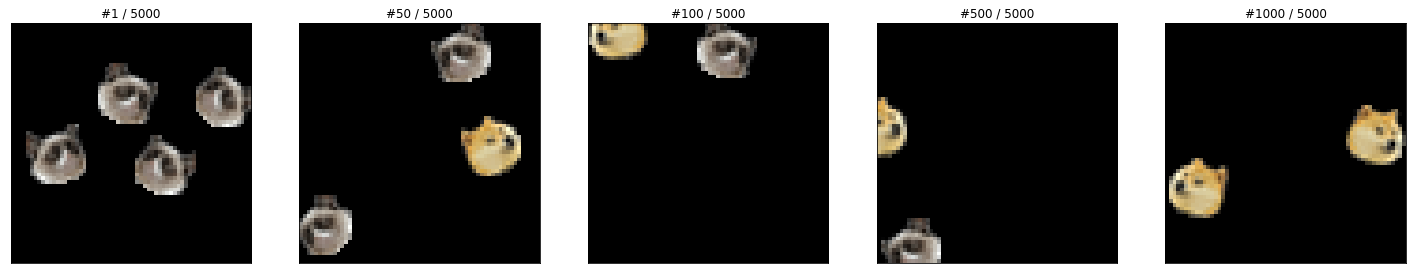

In [12]:
fig = plt.figure(figsize=(25, 5))
axes = fig.subplots(1, 5)
samples = [1, 50, 100, 500, 1000]
for ax, sample in zip(axes, samples):
    im = Image.open(f"images/{sample}.png")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"#{sample} / {dataset_size}")
    ax.imshow(im)

## Часть вторая, в которой появляется модель

### Импорты

In [13]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import backend as K
from keras.preprocessing.image import img_to_array
import numpy as np
import sys

In [14]:
tf.compat.v1.disable_v2_behavior()

### YOLO

In [15]:
nb_boxes=1
grid_w=2
grid_h=2
cell_w=32
cell_h=32
img_w=grid_w*cell_w
img_h=grid_h*cell_h

#
# Read input image and output prediction
#
def load_image(j):
    img = Image.open('images/%d.png' % j)
    
    x_t = img_to_array(img)

    with open("labels/%d.txt" % j, "r") as f:
        y_t = []
        for row in range(grid_w):
            for col in range(grid_h):
                c_t = [float(i) for i in f.readline().split()]
                [x, y, w, h] = [float(i) for i in f.readline().split()]        
                conf_t = [float(i) for i in f.readline().split()]                
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x/cell_w, y/cell_h, w/img_w, h/img_h] + conf_t
                y_t.append(elt)
        assert(f.readline()=="---\n")
        
    return [x_t, y_t]

#
# Define the deep learning network
#

# model 2
i = Input(shape=(img_h,img_w,3))

x = Conv2D(16, (1, 1))(i)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (3, 3))(x)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w*grid_h*(3+nb_boxes*5), activation='sigmoid')(x)
x = Reshape((grid_w*grid_h,(3+nb_boxes*5)))(x)

model = Model(i, x)

#
# The loss function orient the backpropagation algorithm toward the best direction.
#It does so by outputting a number. The larger the number, the further we are from a correct solution.
#Keras also accept that we output a tensor. In that case it will just sum all the numbers to get a single number.
# 
# y_true is training data
# y_pred is value predicted by the network
tf.autograph.experimental.do_not_convert
def custom_loss(y_true, y_pred):
    # define a grid of offsets
    # [[[ 0.  0.]]
    # [[ 1.  0.]]
    # [[ 0.  1.]]
    # [[ 1.  1.]]]
    grid = np.array([ [[float(x),float(y)]]*nb_boxes   for y in range(grid_h) for x in range(grid_w)])

    # first three values are classes : cat, rat, and none.
    # However yolo doesn't predict none as a class, none is everything else and is just not predicted
    # so I don't use it in the loss
    y_true_class = y_true[...,0:2]
    y_pred_class = y_pred[...,0:2] 

    # reshape array as a list of grid / grid cells / boxes / of 5 elements
    pred_boxes = K.reshape(y_pred[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    true_boxes = K.reshape(y_true[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    
    # sum coordinates of center of boxes with cell offsets.
    # as pred boxes are limited to 0 to 1 range, pred x,y + offset is limited to predicting elements inside a cell
    y_pred_xy   = pred_boxes[...,0:2] + K.variable(grid)
    # w and h predicted are 0 to 1 with 1 being image size
    y_pred_wh   = pred_boxes[...,2:4]
    # probability that there is something to predict here
    y_pred_conf = pred_boxes[...,4]

    # same as predicate except that we don't need to add an offset, coordinate are already between 0 and cell count
    y_true_xy   = true_boxes[...,0:2]
    # with and height
    y_true_wh   = true_boxes[...,2:4]
    # probability that there is something in that cell. 0 or 1 here as it's a certitude.
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # compute the intersection of all boxes at once (the IOU)
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.square(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1)

    # final loss function
    d = xy_loss + wh_loss + conf_loss + clss_loss
    
    if False:
        d = tf.Print(d, [d], "loss")
        d = tf.Print(d, [xy_loss], "xy_loss")
        d = tf.Print(d, [wh_loss], "wh_loss")
        d = tf.Print(d, [clss_loss], "clss_loss")
        d = tf.Print(d, [conf_loss], "conf_loss")
    
    return d

model = Model(i, x)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss=custom_loss, optimizer=adam)

print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 16)        4624      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        4640

Обучим модель.

In [16]:
x_train = []
y_train = []

for j in range(11, dataset_size+1):
    [x,y] = load_image(j)
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)


model.fit(x_train, y_train, batch_size=64, epochs=20)
model.save_weights('weights.h5')

Train on 4990 samples
Epoch 1/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.5785
Epoch 2/20
4990/4990 [==============================] - 12s 2ms/sample - loss: 0.5167
Epoch 3/20
4990/4990 [==============================] - 12s 2ms/sample - loss: 0.4920
Epoch 4/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.4755
Epoch 5/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.4353
Epoch 6/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.2764
Epoch 7/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.1940
Epoch 8/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.1585
Epoch 9/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.1353
Epoch 10/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.1189
Epoch 11/20
4990/4990 [==============================] - 11s 2ms/sample - loss: 0.1062
Epoch 12/20
4990/4990 [=======

## Часть третья, в которой модель применяется на тестовых данных

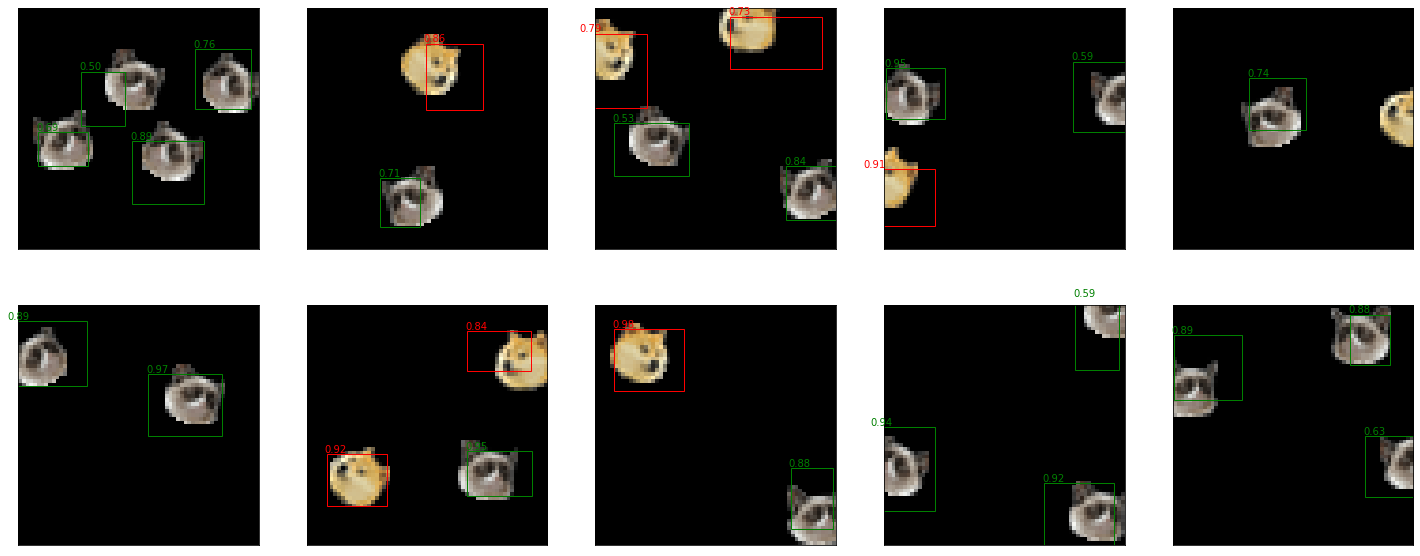

In [17]:
fig = plt.figure(figsize=(25, 10))
axes = fig.subplots(2, 5)

for j in range(10):
    img = Image.open(f"images/{j + 1}.png")
    P = model.predict(np.array([img_to_array(img)]))
 
    for row in range(grid_w):
        for col in range(grid_h):
            p = P[0][col * grid_h + row]

            boxes = p[3:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:2])
            
            ax = axes[j // 5][j % 5]
            ax.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.5:
                    continue

                color = ['r','g','b'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

                ax.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, "%0.2f" % (conf), transform=ax.transAxes, color=color)
                i+=1